In [1]:
%load_ext autoreload
%autoreload 2
%aimport pareto
from pareto import *
from functools import partial
import haiku as hk

In [2]:
alpha = np.array([0.,0.])

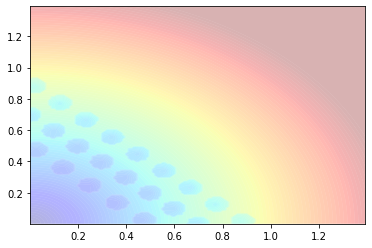

In [3]:
x, y = np.meshgrid(np.arange(0.001, 1.4, 0.01), np.arange(0.001, 1.4, 0.01))
loss_vec = jax.jit(jax.vmap(loss_moguls, in_axes=[0,None]))
z = loss_vec(np.stack((x.flatten(), y.flatten()), 1), alpha).reshape(x.shape)
plt.contourf(x, y, z, alpha=0.3, levels=np.linspace(0., 1.5, 100), cmap=plt.cm.jet, antialiased=True, extend='both')

In [25]:
def get_paths_for_fixed_settings(steps=4000):
  loss_vec = jax.jit(jax.vmap(loss_moguls, in_axes=[0,0]))
  loss_grad = jax.jit(jax.grad(lambda x, a: loss_vec(x, a).sum(), argnums=[0]))

  def compute_next(xy, alpha):
    dxy, = loss_grad(xy, alpha)
    xy = xy - 3e-3 * dxy
    return xy

  xys = INIT_THETAS
  paths = [xys]
  for gradient_step in range(steps):
    xys = compute_next(xys, ALPHAS)
    paths.append(xys)
  paths = np.array(paths[0::20]).transpose(1,2,0)
  
  return paths

In [26]:
paths = get_paths_for_fixed_settings()

In [27]:
paths.shape

(16, 2, 201)

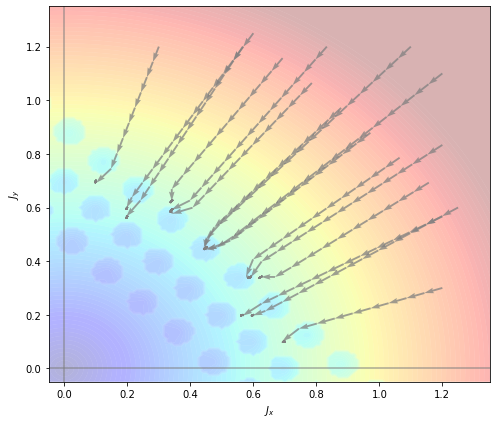

In [28]:
fig, anim = plot_paths([
  paths
])

In [29]:
def _phi(x):
  alpha, itheta = np.split(x, 2, -1)
  module = hk.nets.MLP([4, 256, 256, 2])
  return jax.nn.softplus(module(x) + itheta - 0.5) - 0.05

phi = hk.without_apply_rng(hk.transform(_phi))
phij = jax.jit(phi.apply)

In [30]:
np.concatenate((ALPHAS, INIT_THETAS), 1)

DeviceArray([[0.3       , 0.        , 1.2       , 0.3       ],
             [0.2       , 0.        , 1.2       , 0.56666666],
             [0.1       , 0.        , 1.2       , 0.8333334 ],
             [0.        , 0.        , 1.2       , 1.1       ],
             [0.        , 0.        , 1.1       , 1.2       ],
             [0.        , 0.10000001, 0.8333333 , 1.2       ],
             [0.        , 0.20000002, 0.56666666, 1.2       ],
             [0.        , 0.3       , 0.3       , 1.2       ],
             [0.3       , 0.        , 1.25      , 0.6       ],
             [0.2       , 0.        , 1.1571429 , 0.69285715],
             [0.1       , 0.        , 1.0642858 , 0.7857143 ],
             [0.        , 0.        , 0.9714286 , 0.87857145],
             [0.        , 0.        , 0.87857145, 0.9714286 ],
             [0.        , 0.10000001, 0.78571427, 1.0642858 ],
             [0.        , 0.20000002, 0.69285715, 1.1571429 ],
             [0.        , 0.3       , 0.6       , 1.25 

In [31]:
np.concatenate((ALPHAS, INIT_THETAS), 1)[3:4]

DeviceArray([[0. , 0. , 1.2, 1.1]], dtype=float32)

In [33]:
def get_paths_for_pareto_opt(steps=30000):
  params = phi.init(rng=jax.random.PRNGKey(0), x=np.zeros((4,)))
  PATHS = np.concatenate((ALPHAS, INIT_THETAS), 1)
  
  loss_vec = jax.jit(jax.vmap(loss_moguls, in_axes=[0,0]))
  loss_grad = jax.jit(jax.grad(
    lambda params, ins: loss_vec(phij(params=params, x=ins), np.split(ins, 2, -1)[0]).sum(), 
    argnums=[0]))

  def compute_next(params, ins):
    paramg, = loss_grad(params, ins)
    return jax.tree_map(lambda p, g: p - 1e-4 * g, params, paramg)
  
  xys = phij(params, PATHS)
  paths = [xys]
  for gradient_step in range(steps):
    ins1 = onp.random.random((32,2)) * 0.8 - 0.4
    ins2 = onp.random.random((32,2)) * 0.9 + 0.3
    params = compute_next(params, np.concatenate((ins1, ins2), -1))
    paths.append(phij(params, PATHS))
    
  paths = np.array(paths[0::10]).transpose(1,2,0)
  
  return params, paths

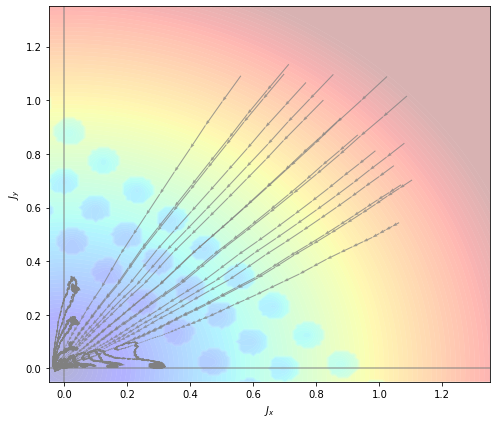

In [35]:
params, paths = get_paths_for_pareto_opt()
fig, anim = plot_paths([
  paths,
])

In [36]:
PATHS = np.concatenate((np.array([[0,0]]), np.array([[1.,1.]])), 1)

In [37]:
phij(params, PATHS)

DeviceArray([[0.01173081, 0.00602842]], dtype=float32)

In [38]:
def get_paths_for_pareto_opt(steps=30000):
  params = phi.init(rng=jax.random.PRNGKey(0), x=np.zeros((4,)))
  PATHS = np.concatenate((ALPHAS, INIT_THETAS), 1)[3:4]
  
  loss_vec = jax.jit(jax.vmap(loss_moguls, in_axes=[0,0]))
  loss_grad = jax.jit(jax.grad(
    lambda params, ins: loss_vec(phij(params=params, x=ins), np.split(ins, 2, -1)[0]).sum(), 
    argnums=[0]))

  def compute_next(params, ins):
    paramg, = loss_grad(params, ins)
    return jax.tree_map(lambda p, g: p - 1e-4 * g, params, paramg)
  
  xys = phij(params, PATHS)
  paths = [xys]
  for gradient_step in range(steps):
    ins1 = onp.random.random((32,2)) * 0.8 - 0.4
    ins2 = onp.random.random((32,2)) * 0.9 + 0.3
    params = compute_next(params, np.concatenate((ins1, ins2), -1))
    paths.append(phij(params, PATHS))
    
  paths = np.array(paths[0::10]).transpose(1,2,0)
  
  return params, paths

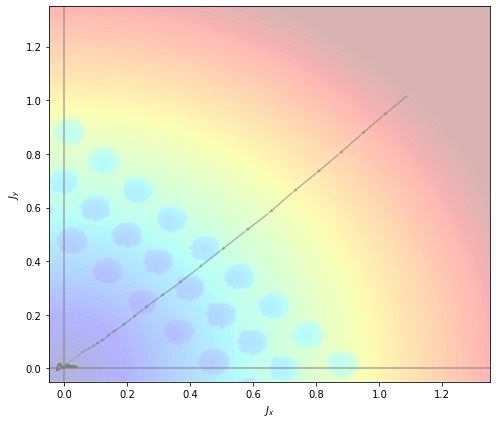

In [39]:
params, paths = get_paths_for_pareto_opt()
fig, anim = plot_paths([
  paths,
])

In [40]:
def get_paths_for_pareto_opt(steps=30000):
  params = phi.init(rng=jax.random.PRNGKey(0), x=np.zeros((4,)))
  PATHS = np.concatenate((ALPHAS, INIT_THETAS), 1)[3:4]
  
  loss_vec = jax.jit(jax.vmap(loss_moguls, in_axes=[0,0]))
  loss_grad = jax.jit(jax.grad(
    lambda params, ins: loss_vec(phij(params=params, x=ins), np.split(ins, 2, -1)[0]).sum(), 
    argnums=[0]))

  def compute_next(params, ins):
    paramg, = loss_grad(params, ins)
    return jax.tree_map(lambda p, g: p - 1e-4 * g, params, paramg)
  
  xys = phij(params, PATHS)
  paths = [xys]
  for gradient_step in range(steps):
    params = compute_next(params, PATHS)
    paths.append(phij(params, PATHS))
    
  paths = np.array(paths[0::10]).transpose(1,2,0)
  
  return params, paths

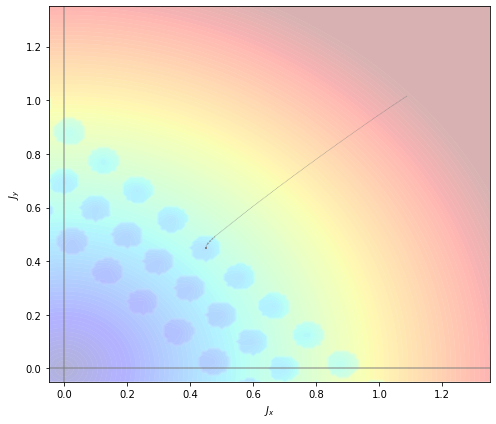

In [41]:
params, paths = get_paths_for_pareto_opt()
fig, anim = plot_paths([
  paths,
])

In [16]:
#HTML(anim.to_html5_video())